#Preprocesamiento de datos

In [ ]:
import pickle
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
sns.set_style(style='white')

In [ ]:
!gdown --id 1Mpk-C-msTdfZJK88IiaEHrV4Jez4l0PV #https://drive.google.com/file/d/1Mpk-C-msTdfZJK88IiaEHrV4Jez4l0PV/view?usp=sharing
!unzip ObesityDataSet_raw_and_data_sinthetic.zip

Downloading...
From: https://drive.google.com/uc?id=1Mpk-C-msTdfZJK88IiaEHrV4Jez4l0PV
To: /content/ObesityDataSet_raw_and_data_sinthetic.zip
100% 119k/119k [00:00<00:00, 38.7MB/s]
Archive:  ObesityDataSet_raw_and_data_sinthetic.zip
replace ObesityDataSet_raw_and_data_sinthetic.arff? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ObesityDataSet_raw_and_data_sinthetic.arff  
  inflating: ObesityDataSet_raw_and_data_sinthetic.csv  


In [ ]:
data=pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")

In [ ]:
numeric=["Age","Height","Weight","FCVC","NCP","CH2O","FAF","TUE"]
ordinal=["CAEC","CALC"]
flags=["family_history_with_overweight","FAVC","SMOKE","SCC"]
categorical=["MTRANS","Gender"]

In [ ]:
data.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [ ]:
data["CAEC"]=data["CAEC"].map({"no":0,"Sometimes":1,"Frequently":2,"Always":3})

In [ ]:
data["CALC"]=data["CALC"].map({"no":0,"Sometimes":1,"Frequently":2,"Always":3})

In [ ]:
#Se usa la función get_dummies para codificar en one hot encoding los datos categóricos ("MTRANS" y "Gender") y el drop_first para no tener columnas altamente correlacionadas
data = pd.get_dummies(data, columns=categorical, drop_first=True)
data.head()

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,NObeyesdad,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,Gender_Male
0,21.0,1.62,64.0,yes,no,2.0,3.0,1,no,2.0,no,0.0,1.0,0,Normal_Weight,0,0,1,0,0
1,21.0,1.52,56.0,yes,no,3.0,3.0,1,yes,3.0,yes,3.0,0.0,1,Normal_Weight,0,0,1,0,0
2,23.0,1.80,77.0,yes,no,2.0,3.0,1,no,2.0,no,2.0,1.0,2,Normal_Weight,0,0,1,0,1
3,27.0,1.80,87.0,no,no,3.0,3.0,1,no,2.0,no,2.0,0.0,2,Overweight_Level_I,0,0,0,1,1
4,22.0,1.78,89.8,no,no,2.0,1.0,1,no,2.0,no,0.0,0.0,1,Overweight_Level_II,0,0,1,0,1


In [ ]:
# Se realiza la codificación para las variables con datos binarios
for column in flags:
    data[column]=data[column].map({"yes":1,"no":0})

In [ ]:
data.head()

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,NObeyesdad,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,Gender_Male
0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,Normal_Weight,0,0,1,0,0
1,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,Normal_Weight,0,0,1,0,0
2,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,Normal_Weight,0,0,1,0,1
3,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,Overweight_Level_I,0,0,0,1,1
4,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,Overweight_Level_II,0,0,1,0,1


In [ ]:
# Se realiza la codificación para la variable objetivo
data["NObeyesdad_num"]=data["NObeyesdad"].map({"Insufficient_Weight":0,"Normal_Weight":1,"Overweight_Level_I":2,
                                           "Overweight_Level_II":3,"Obesity_Type_I":4,"Obesity_Type_II":5,
                                           "Obesity_Type_III":6})

In [ ]:
# Se realiza la creación de la variable BMI (Índice de masa corporal)
data["BMI"]=data["Weight"]/(data["Height"]*data["Height"])

#Generar conjunto de datos de entrenamiento y pruebas

In [ ]:
#Separamos la data en variables independientes (x) y dependientes (y) para poder entrenarlas
#En el conjunto de datos x se replican todos las columnas después del procesamiento excluyendo al target ["NObeyesdad","NObeyesdad_num"]
#En el conjunto de datos y solo consideta la columna del target ["NObeyesdad_num"]
x = data.drop(["NObeyesdad","NObeyesdad_num"], axis=1)
y = data["NObeyesdad_num"]

In [ ]:
#Mediante la función "train_test_split" usaremos el 20% de la data para probar el modelo 
#El parámetro "random state" nos sirve para obtener la misma secuencia de "números aleatorios"
#El parámetro "stratify" nos brindará el mismo número de clases en ambos conjuntos de datos 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print(f"x Train shape: {x_train.shape}")
print(f"x Test shape: {x_test.shape}")
print(f"y Train shape: {y_train.shape}")
print(f"y Test shape: {y_test.shape}")

x Train shape: (1688, 20)
x Test shape: (423, 20)
y Train shape: (1688,)
y Test shape: (423,)


In [ ]:
#Se muestra la información del conjunto de datos x_train
print(x_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 442 to 1329
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             1688 non-null   float64
 1   Height                          1688 non-null   float64
 2   Weight                          1688 non-null   float64
 3   family_history_with_overweight  1688 non-null   int64  
 4   FAVC                            1688 non-null   int64  
 5   FCVC                            1688 non-null   float64
 6   NCP                             1688 non-null   float64
 7   CAEC                            1688 non-null   int64  
 8   SMOKE                           1688 non-null   int64  
 9   CH2O                            1688 non-null   float64
 10  SCC                             1688 non-null   int64  
 11  FAF                             1688 non-null   float64
 12  TUE                             

#Configuraciones

In [ ]:
#Función donde se envía el modelo y genera la matriz de confusión basándose en los datos predichos
def plot_confusion_matrix(model):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix","\n")
    index = ["Insufficient_Weight","Normal_Weight","Overweight_Level_I","Overweight_Level_II","Obesity_Type_I","Obesity_Type_II","Obesity_Type_III"] 
    columns = index
    conf_matrix = pd.DataFrame(cm,columns,index)  
    plt.figure(figsize=(10,6))                     
    sns.heatmap(conf_matrix, annot = True)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.show()
    print("\n")   

In [ ]:
#Función que construye un reporte mostrando las principales métricas de classificación como precision y recall
def get_test_report(model):
    test_pred = model.predict(x_test)
    return(classification_report(y_test, test_pred))

In [ ]:
#Función que muestra características que más aportan al modelo en orden de importancia
def get_features(model):
  importances = pd.DataFrame({"columns":x_train.columns, "importances":model.feature_importances_}).sort_values("importances", ascending=False)
  return(importances.style.bar())

#Construir los modelos

##Modelo Ramdon Forest


In [ ]:
#Entrenamos el modelo "RandomForestClassifier" usando la función "GridSearchCV" para considerar la mejor combinación de los hiperparámetros
rf= RandomForestClassifier(random_state=1)

#Se asignan los hiperparámetros a evaluar
pg_rf={'criterion': ['gini', 'entropy'],'max_depth': [18, 20, 22], 'n_estimators': [2000,2600,2800], 
       'oob_score': [True, False], 'max_features':['sqrt', 'auto'], }

#Se configura el "GridSearchCV"
gs_rf= GridSearchCV (estimator= rf,
                    param_grid= pg_rf,
                    scoring='f1_macro',
                    cv=2)

#Se hace validación cruzada anidada combinando en el grid search (bucle interno) y k-fold cv (bucle externo)
gs_rf_scores = cross_val_score(gs_rf, X=x_train, y=y_train, cv=3, scoring='f1_macro', verbose = 10, n_jobs=-1)

#Se entrena el "GridSearchCV" en los conjuntos de datos de entrenamiento
gs_rf.fit(x_train, y_train)

#Se muestran los resultados obtenidos después de realizado la búsqueda de parámetros
print('Train Accuracy:   {0:.1f}%'.format(gs_rf.score(x_train, y_train)*100))
print('CV Mean Accuracy: {0:.1f}%'.format(np.mean(gs_rf_scores)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_rf.score(x_test, y_test)*100))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 39.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 39.9min finished


Train Accuracy:   100.0%
CV Mean Accuracy: 98.7%
Test Accuracy:    99.0%


In [ ]:
#Se muestra los mejores parámetros obtenidos por el "GridSearchCV"
gs_rf_best=gs_rf.best_estimator_
print(gs_rf_best)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=18, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2600,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)


In [ ]:
#Reporte de la búsqueda de las configuraciones del modelo
gs_rf.best_estimator_
#Imprime la mejor configuración obtenida 
print("Best: %f using %s" % (gs_rf.best_score_, gs_rf.best_params_))
#Imprime todas las configuraciones ejecutadas
means = gs_rf.cv_results_['mean_test_score']
stds = gs_rf.cv_results_['std_test_score']
params = gs_rf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.985328 using {'criterion': 'entropy', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 2600, 'oob_score': True}
0.983480 (0.000788) with: {'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 2000, 'oob_score': True}
0.983480 (0.000788) with: {'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 2000, 'oob_score': False}
0.982922 (0.001346) with: {'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 2600, 'oob_score': True}
0.982922 (0.001346) with: {'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 2600, 'oob_score': False}
0.982922 (0.001346) with: {'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 2800, 'oob_score': True}
0.982922 (0.001346) with: {'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 2800, 'oob_score': False}
0.983480 (0.000788) with: {'criterion': 'gini', 'max_depth': 18, 'max_features': 'auto', 

In [ ]:
#Reporte con las principales métricas de classificación de los datos predichos generados por el modelo
print(get_test_report(gs_rf))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.98      1.00      0.99        58
           2       0.98      1.00      0.99        58
           3       1.00      0.98      0.99        58
           4       1.00      1.00      1.00        70
           5       0.98      0.98      0.98        60
           6       0.98      0.98      0.98        65

    accuracy                           0.99       423
   macro avg       0.99      0.99      0.99       423
weighted avg       0.99      0.99      0.99       423



Confusion Matrix 



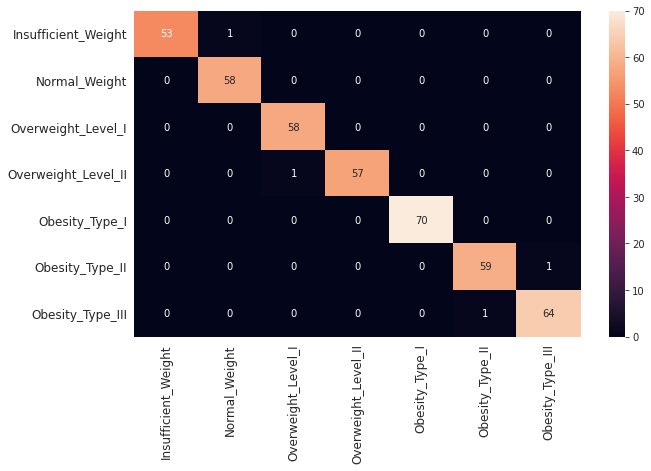

In [ ]:
# Reporte de la matriz de confusión de los datos predichos generados por el modelo
plot_confusion_matrix(gs_rf)

In [ ]:
# Reporte de las características que más aportan al modelo
get_features(gs_rf_best)

,columns,importances
19,BMI,0.392380
2,Weight,0.218006
5,FCVC,0.067044
18,Gender_Male,0.053785
0,Age,0.051264
1,Height,0.043645
6,NCP,0.028817
3,family_history_with_overweight,0.023199
12,TUE,0.022179
7,CAEC,0.020098
